In [1]:
import pandas as pd
import numpy as np
import pyclustertend 
import random
import sklearn.cluster as cluster
import sklearn.metrics as metrics

from sklearn.metrics import silhouette_samples, silhouette_score
import sklearn.preprocessing
from sklearn.datasets import make_classification
from sklearn.cluster import Birch, KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm


### Pregunta 1

In [2]:
movies = pd.read_csv('movies.csv', encoding = "ISO-8859-1")
columns = list(movies.describe().columns[1:])
columns.append('actorsPopularity')
columns.append('castWomenAmount')
columns.append('castMenAmount')

popular = []
variables = movies.loc[:, movies.columns.isin(columns)]
for index, row in variables.iterrows():
  try:

    data = row['actorsPopularity'].split('|')
    value = np.sort(np.array(data).astype(float))[-1]
    # Aqui se observa si los datos tienen sentido
    if (
      row['budget'] >= 300000000 or 
      row['revenue'] >= 1200000000 or
      row['runtime'] >= 300 or
      row['popularity'] >= 900 or
      row['voteCount'] >= 20000 or
      row['genresAmount'] >= 10 or
      row['productionCoAmount'] >= 25 or
      row['productionCountriesAmount'] >= 20 or
      row['actorsAmount'] >= 200 or
      int(row['castWomenAmount']) >= 55 or
      int(row['castMenAmount']) >= 100
    ):
      variables = variables.drop(index=index)
      continue
    popular.append(value)
  except:
    variables = variables.drop(index=index)

variables['popular'] = popular
variables = variables.drop('actorsPopularity', axis='columns')

variables = variables.astype({'castWomenAmount': int, 'castMenAmount': int})
normalized_variables = (variables-variables.min())/(variables.max()-variables.min())

### Pregunta 2

In [3]:
random.seed(123)
X_scale=sklearn.preprocessing.scale(variables)

pyclustertend.hopkins(X_scale, len(X_scale))

0.0847393760722384

El valor de hopkins es de 0.085, por lo que vale la pena hacer el agrupamiento.

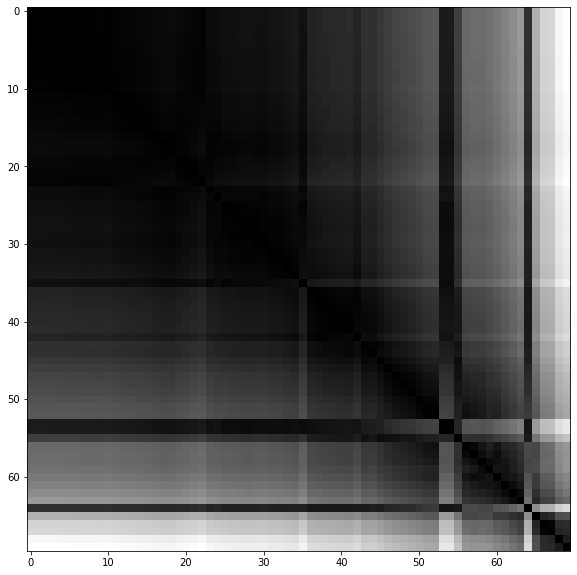

In [4]:
pyclustertend.vat(variables[:70])

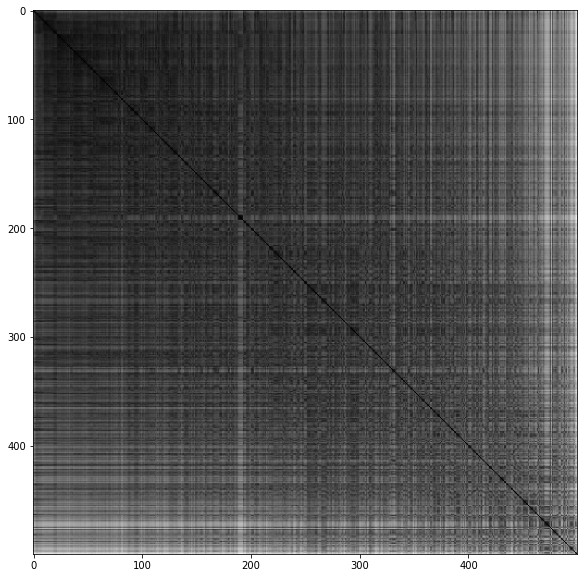

In [5]:
pyclustertend.vat(X_scale[:500])

### Pregunta 3

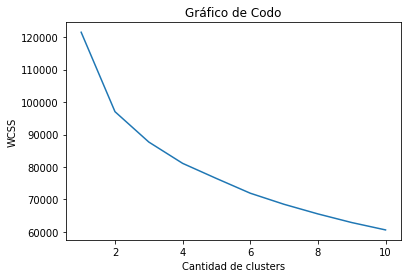

In [6]:
numeroClusters = range(1,11)

wcss = []
# Obtenemos 10 posibles clusters
for i in numeroClusters:
    # Se calcula la kmean con esa cantidad de clusters
    kmeans = cluster.KMeans(n_clusters=i)
    kmeans.fit(X_scale)
    # Obtenemos la inercia
    wcss.append(kmeans.inertia_)

# Graficando
plt.plot(numeroClusters, wcss)
plt.xlabel("Cantidad de clusters")
plt.ylabel("WCSS")
plt.title("Gráfico de Codo")
plt.show()

### Pregunta 4 - Metodo de K-Medias

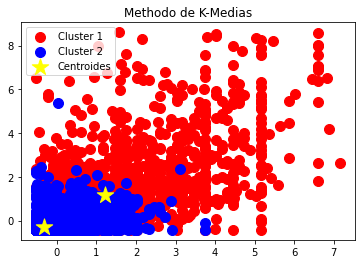

In [41]:
kmeans_cluster = KMeans(n_clusters=2)
kmeans_cluster.fit(X_scale)
kmeans_result = kmeans_cluster.predict(X_scale)

# Plot
plt.scatter(X_scale[kmeans_result == 0, 0], X_scale[kmeans_result == 0, 1], s = 100, c = 'red', label = "Cluster 1")
plt.scatter(X_scale[kmeans_result == 1, 0], X_scale[kmeans_result == 1, 1], s = 100, c = 'blue', label = "Cluster 2")
plt.scatter(kmeans_cluster.cluster_centers_[:,0], kmeans_cluster.cluster_centers_[:,1], s=300, c="yellow",marker="*", label="Centroides")
plt.title("Methodo de K-Medias")
plt.legend()
plt.show()

### Pregunta 4 - Metodo de BIRCH
Referencia de: https://www.freecodecamp.org/espanol/news/8-algoritmos-de-agrupacion-en-clusteres-en-el-aprendizaje-automatico-que-todos-los-cientificos-de-datos-deben-conocer/

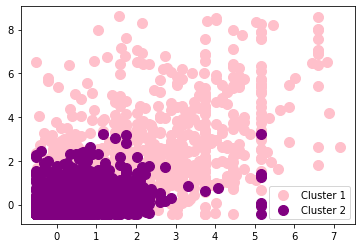

In [38]:
# Inicializar el modelo
birch_model = Birch(threshold=1.5, n_clusters=2)
birch_model.fit(X_scale)

# Obtenemos los puntos y los clusters
birch_result = birch_model.predict(X_scale)

# Graficar los clusters
plt.scatter(X_scale[birch_result == 0, 0], X_scale[birch_result == 0, 1], s = 100, c = 'pink', label = "Cluster 1")
plt.scatter(X_scale[birch_result == 1, 0], X_scale[birch_result == 1, 1], s = 100, c = 'purple', label = "Cluster 2")
plt.title("Methodo de BIRCH")
plt.legend()
plt.show()


### Pregunta 5

For n_clusters = 2 The average silhouette_score is : 0.3300336486630215
For n_clusters = 3 The average silhouette_score is : 0.20189727691353304
For n_clusters = 4 The average silhouette_score is : 0.20133626979994812
For n_clusters = 5 The average silhouette_score is : 0.20862359774175981


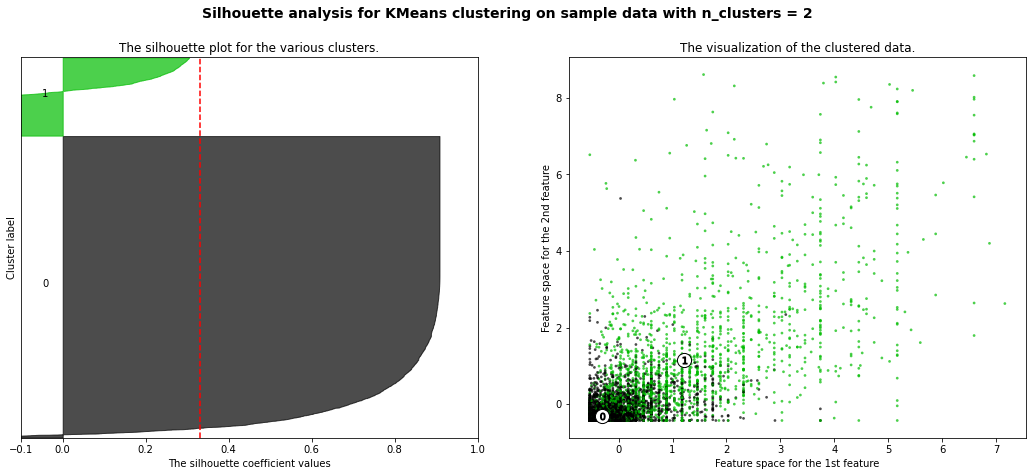

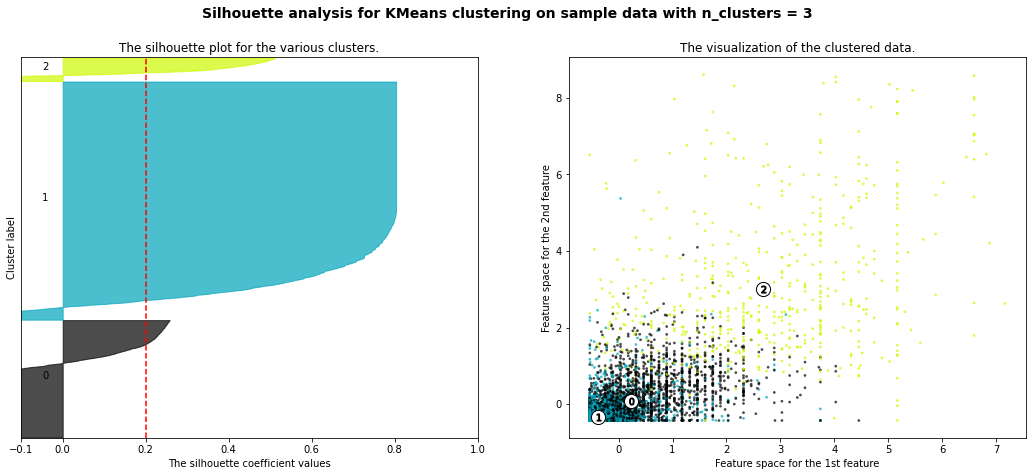

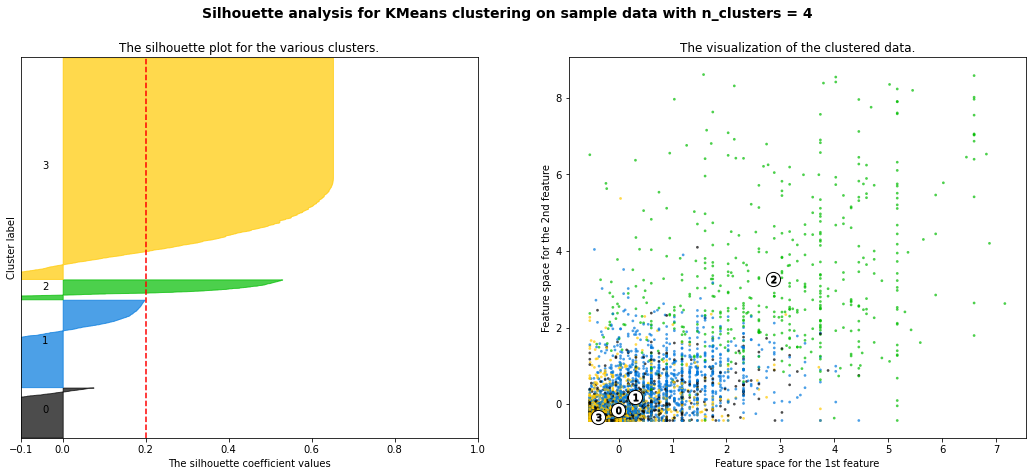

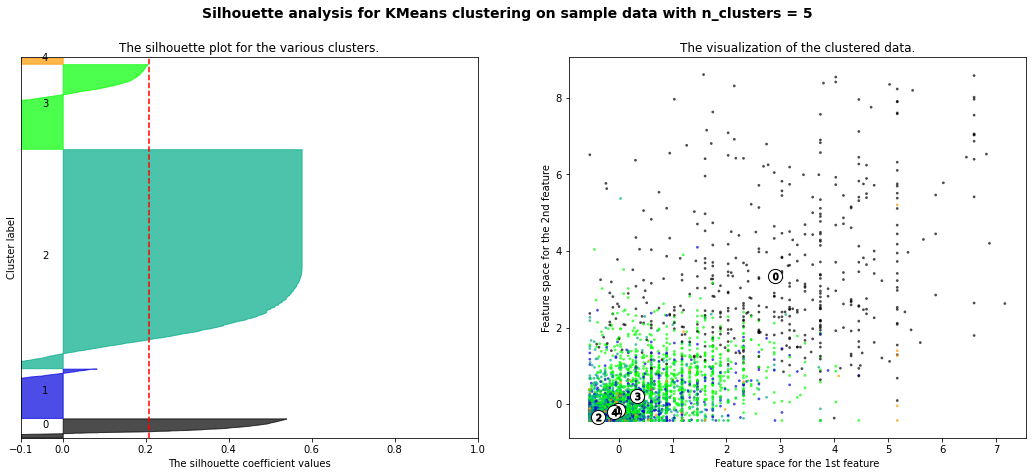

In [8]:
for n_clusters in range(2, 6):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_scale) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_scale)

    silhouette_avg = silhouette_score(X_scale, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    sample_silhouette_values = silhouette_samples(variables, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([]) 
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
       X_scale[:, 0], X_scale[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    centers = clusterer.cluster_centers_
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()